# Panini Monte Carlo Simulation

# Libraries

In [1]:
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
import random
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)

In [2]:
# Properties
n_stickers = 678
cost_per_packs = 1.1
pack_size = 5

## Album

In [20]:
class Album:
    '''
    Attributes
    ----------
    album : np.array of size n_stickers
        The value at index i determines the amount of stickers with this id are collected.
    album_complete : int=0
        Turns to 1 as soon as the album is complete
    n_stickers : int
        Number of stickers in the album
    pack_size : int
        Size of a pack of stickers
    num_packs_bought : int
        The amount of packst that had to be bought until the album was complete
    
    
    Methods
    -------
    create_pack
        Creates a pack of uniformely distributed stickers
    buy_pack
        Simulates the buying process of on sticker pack and adds the sickers to the album
    fill_album
        Buys stickers until at least one of every sticker is in the album
    '''

    def __init__(self, n_stickers, pack_size):
        '''
        Parameters
        ----------
        n_stickers : int
            Number of stickers in the album
        pack_size : int
            Size of a pack of stickers
        '''
        
        self.n_stickers = n_stickers
        self.stickers = np.zeros(n_stickers)
        self.pack_size = pack_size
        self.num_packs_bought = 0
        self.album_complete = 0
    
    def create_pack(self):
        '''
        Creates a sticker pack that contains n stickers defined by the pack size.
        The stickers are distributed uniformly

        Returns
        --------
        Numpy array
            Random selected stickers of size pack_size
        '''
        
        rng = np.random.default_rng()
        return(rng.integers(low=0, high=self.n_stickers, size=self.pack_size))

    
    def buy_pack(self):
        '''
        Simulates the buying process of on sticker pack.

        Creates a new sticker pack. The stickers that are contained inside this pack
        are then added to the album. The sticker number is the ID in the album. Thus, 1 is added
        to the album array at the index i=sticker_number.
        '''

        new_stickers = self.create_pack()
        for i in new_stickers:
            self.stickers[i] += 1

    def buy_missing_stickers(self):
        '''
        When the number of missing stickers is less than 51, these are bought directly.
        '''
        missing_stickers = np.argwhere(self.stickers == 0)
        num_missing_stickers = missing_stickers.shape[0]
        if num_missing_stickers < 51:
            self.stickers[missing_stickers] += 1
            self.num_packs_bought += num_missing_stickers/5
        
        
    def fill_album(self):
        '''
        Buys stickers until the album is full.
        '''
        # Check if album still contains zeros
        # if not -> buy new pack
        # if yes, stop
        while (self.stickers==0).any():
            self.buy_pack() 
            self.num_packs_bought += 1
                
        self.album_complete = True

In [25]:
def initialize_mc_simulation(n_album, n_stickers, pack_size):
    # generate n albums instances
    albums = [Album(n_stickers, pack_size) for i in range(n_album)]
    return albums

def run_mc_simulation_swapping(n_simulations, n_albums, n_stickers, pack_size, complete_swap = False, buy_missing_stickers = False):
    '''
    Runs the MC simulation including swapping
    
    Parameters
    ----------
    n_simulations : int
        Number of simulation steps
    n_albums : int = 
        Number of albums (i.e. collectors) in the simulatoin
    n_sitckers : int
        Number of stickers of one album
    pack_size : int
        Size of a sicker pack    
    complete_swap : bool (False)
        Complete albums sell the duplicated stickers to the others
    buy_missing_stickers : bool (False)
        When the number of missing stickers is less than 51, these are bought directly
    
    Returns
    -------
    list
        A list of each album of all stickers that were bought
    list
        Number of packs that had to be bought to complete the album
    int
        Number of stickers that were sold by complete albums
    '''
    num_sold_stickers = 0
    num_packs_fill_album = []
    alb = []
    
    # Running n_simulations/n_albums simulations.
    for i in range(int(np.ceil(n_simulations/n_albums))):
        # Verbose
        #if i%100 == 0: print('Simulation Number: {}'.format(i))
        # Initialize the albums
        albums = initialize_mc_simulation(n_albums, n_stickers, pack_size)
        # As long as any of the albums is not yet complete-> Run the Simulation
        while (np.array([albums[i].album_complete for i in range(len(albums))])==0).any(): 
            # For each album that is not yet complete, buy a pack of stickers and check
            # if the album is now full.
            for i in range(len(albums)):
                if albums[i].album_complete == 0: 
                    # Check less than 51 stickers are missing. If yes, they can be bought directly (from panini.ch)
                    albums[i].buy_missing_stickers()
                    # Buy sticker pack
                    albums[i].buy_pack() 
                    albums[i].num_packs_bought += 1
                    # Check if album is complete
                    if ~(albums[i].stickers==0).any():
                        albums[i].album_complete = 1
                        num_packs_fill_album.append(albums[i].num_packs_bought)
                        alb.append(albums[i].stickers)
                    
                
            # Perform swapping between all albums.
            albums, sold_stickers = swap_stickers(albums, complete_swap)
            num_sold_stickers += sold_stickers  
                
    
    return alb[:n_simulations], num_packs_fill_album[:n_simulations], num_sold_stickers

def swap_stickers(albums, complete_swap = False):
    '''
    Swaps the stickers between each album.
    
    Parameters
    ----------
    albums : list
        List of the albums that participate the swapping process
    complete_swap : bool (False)
        Complete albums sell the duplicated stickers to the others.
    
    Returns
    -------
    albums : List
        List of the albums with swapped stickers
    num_sold_stickers : int
        Number of stickers that were sold by complete albums
    '''
    num_sold_stickers = 0
    num_alubms = len(albums)
    # generate swapping order
    swapping_order = generate_swapping_order(num_alubms)
    
    # swap for each swapping_order
    for swapping in swapping_order:
        swap_album_0 = swapping[0]
        swap_album_1 = swapping[1]
        # Count the amount of stickers that can be swapped
        # Number of 0 in first array, where >1 in second.
        swap_0_to_1 = np.argwhere((albums[swap_album_0].stickers > 1) & (albums[swap_album_1].stickers == 0)==True)
        # Number of 0 in the second array, where >1 in the first
        swap_1_to_0 = np.argwhere((albums[swap_album_1].stickers > 1) & (albums[swap_album_0].stickers == 0)==True)
        
        # If 0 has a complete album, 0 sells all stickers that 1 needs
        if albums[swap_album_0].album_complete == 1 and complete_swap == True:
            number_of_swaps = len(swap_0_to_1)
            # Add the # of stickers that are sold from 0 to 1 to the number of bought packs of 1
            albums[swap_album_1].num_packs_bought += number_of_swaps/5
            num_sold_stickers += number_of_swaps
        # If 1 has a complete album, 1 sells all stickers that 0 needs
        elif albums[swap_album_1].album_complete == 1 and complete_swap == True:
            number_of_swaps = len(swap_1_to_0)
            # Add the # of stickers that are sold from 1 to 0 to the number of bought packs of 0
            albums[swap_album_0].num_packs_bought += number_of_swaps/5
            num_sold_stickers += number_of_swaps
        # The lower length of the two arrays determine the number of swaps  
        else:
            number_of_swaps = np.amin(np.array([len(swap_0_to_1), len(swap_1_to_0)]))
        
        # Swapping
        for i in range(number_of_swaps):
            # If 0 has a complete album, 0 sells all stickers that 1 needs
            if (albums[swap_album_0].album_complete == 1 and complete_swap == True):
                # 0 gives sticker to 1
                albums[swap_album_0].stickers[swap_0_to_1[i]] -= 1
                albums[swap_album_1].stickers[swap_0_to_1[i]] += 1
            elif albums[swap_album_1].album_complete == 1 and complete_swap == True:
                 # 1 gives sticker to 0
                albums[swap_album_0].stickers[swap_1_to_0[i]] += 1
                albums[swap_album_1].stickers[swap_1_to_0[i]] -= 1
            else:
                # 0 gives sticker to 1
                albums[swap_album_0].stickers[swap_0_to_1[i]] -= 1
                albums[swap_album_1].stickers[swap_0_to_1[i]] += 1
                # 1 gives sticker to 0
                albums[swap_album_0].stickers[swap_1_to_0[i]] += 1
                albums[swap_album_1].stickers[swap_1_to_0[i]] -= 1
    
    return albums, num_sold_stickers

def generate_swapping_order(num_albums):
    '''
    Generates swapping combinations and shuffles them.
    
    Parameters
    ----------
    num_albums : int
        Number of albums that participate the swapping process
        
    Example
    -------
    random_swapping_order(5)
    > [[2,4], [1,3], [0,4], [0,3], [1,2], [0,2], 
       [2,3], [0,1], [3,4], [1,4]]
    
    '''
    
    # Generate possible swapping combinatoins
    swapping_order = []
    for i in range(num_albums-1):
        for j in range(i+1, num_albums):
            swapping_order.append([i,j])
    
    # Shuffle the swapping order
    random.shuffle(swapping_order)
    
    return swapping_order

## Perform the MC simulation for different number of albums (i.e. collectors) including swapping

In [29]:
albums = []
num_packs_fill_album = []
for num_albums in range(1,20):
    print('# of albums in simulation: {}'.format(num_albums))
    alb, num_packs_fill, num_sold_stickers = run_mc_simulation_swapping(2000,
                                                                        num_albums, 
                                                                        n_stickers, 
                                                                        pack_size, 
                                                                        complete_swap = True, 
                                                                        buy_missing_stickers = False)
    albums.append(alb)
    num_packs_fill_album.append(num_packs_fill)

# of albums in simulation: 1
# of albums in simulation: 2
# of albums in simulation: 3
# of albums in simulation: 4
# of albums in simulation: 5
# of albums in simulation: 6
# of albums in simulation: 7
# of albums in simulation: 8
# of albums in simulation: 9
# of albums in simulation: 10
# of albums in simulation: 11
# of albums in simulation: 12
# of albums in simulation: 13
# of albums in simulation: 14
# of albums in simulation: 15
# of albums in simulation: 16
# of albums in simulation: 17
# of albums in simulation: 18
# of albums in simulation: 19


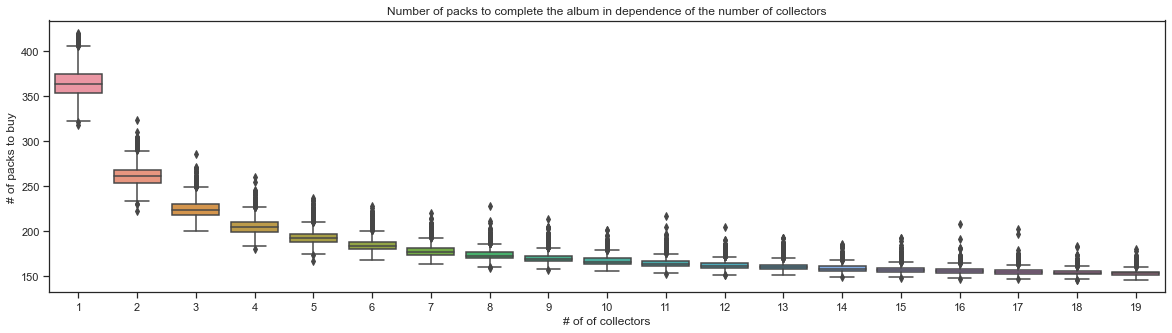

In [34]:
df = pd.DataFrame(data=np.transpose(num_packs_fill_album), columns=np.arange(1,len(num_packs_fill_album)+1))#np.linspace(1, len(num_packs_fill_album), len(num_packs_fill_album)))
fig, axes = plt.subplots(1, 1, figsize=(20,5))
sns.boxplot(ax=axes, x="variable", y="value", data=pd.melt(df))
axes.set_title('Number of packs to complete the album in dependence of the number of collectors')
axes.set(ylabel='# of packs to buy');
axes.set(xlabel='# of of collectors');

fig.savefig('img/swapping/no_of_packs_swapping_buy_last.png')

In [123]:
albums, num_packs_fill_album = run_mc_simulation_swapping(1500, 5, n_stickers, pack_size)

Simulation Number: 0
Simulation Number: 100
Simulation Number: 200
1500


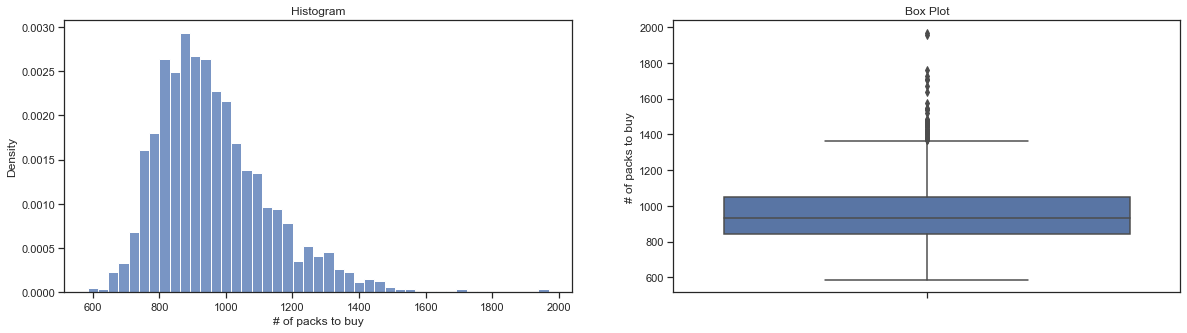

In [8]:
# No Swapping
fig, axes = plt.subplots(1, 2, figsize=(20,5))
sns.histplot(ax=axes[0], x=num_packs_fill_album[0],  bins='sqrt', stat='density');
axes[0].set(ylabel='Density', xlabel='# of packs to buy');
axes[0].set_title('Histogram')
#sns.violinplot(ax=axes[1], y=num_packs_fill_album);
#axes[1].set_title('Violin Plot')
#axes[1].set(ylabel='# of packs to buy');
sns.boxplot(ax=axes[1], y=num_packs_fill_album[0]);
axes[1].set_title('Box Plot')
axes[1].set(ylabel='# of packs to buy');

#fig.savefig('no_of_packs_two_swappers')

In [42]:
print('#### No Swapping ####')
print('The median number of packs one has to buy to fill the complete album is: {}'.format(np.median(num_packs_fill_album[0])))
print('With a chance of 10%, you need less than {} packs to fill the album '.format(np.percentile(num_packs_fill_album[0], 10)))
print('With a chance of 10%, you need more than {} packs to fill the album '.format(np.percentile(num_packs_fill_album[0], 90)))

print('\n#### Five collectors ####')
print('The median number of packs one has to buy to fill the complete album is: {}'.format(np.median(num_packs_fill_album[4])))
print('With a chance of 10%, you need less than {} packs to fill the album '.format(np.percentile(num_packs_fill_album[4], 10)))
print('With a chance of 10%, you need more than {} packs to fill the album '.format(np.percentile(num_packs_fill_album[4], 90)))

#### No Swapping ####
The median number of packs one has to buy to fill the complete album is: 363.0
With a chance of 10%, you need less than 343.0 packs to fill the album 
With a chance of 10%, you need more than 385.0 packs to fill the album 

#### Five collectors ####
The median number of packs one has to buy to fill the complete album is: 192.0
With a chance of 10%, you need less than 184.0 packs to fill the album 
With a chance of 10%, you need more than 203.4 packs to fill the album 


## Evaluate the duplicates

In [43]:
duplicates = []
amount_of_duplicates = []

for i in range(len(albums)):
    dup = np.zeros(40) 
    n_duplicates = []
    for album in albums[i]:  
        n_duplicates.append(np.sum(album) - n_stickers) 
        counts = np.bincount(np.int64(album))
        len_counts = len(counts)
        dup[0:len_counts] = dup[0:len_counts] + counts
    duplicates.append(dup)
    amount_of_duplicates.append(n_duplicates)

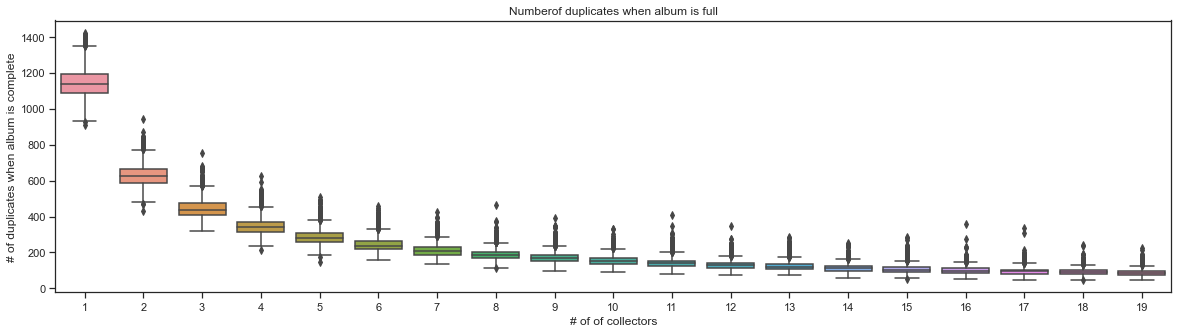

In [44]:
df = pd.DataFrame(data=np.transpose(amount_of_duplicates), columns=np.arange(1,len(amount_of_duplicates)+1))#np.linspace(1, len(num_packs_fill_album), len(num_packs_fill_album)))
fig, axes = plt.subplots(1, 1, figsize=(20,5))
sns.boxplot(ax=axes, x="variable", y="value", data=pd.melt(df))
axes.set_title('Numberof duplicates when album is full')
axes.set(ylabel='# of duplicates when album is complete');
axes.set(xlabel='# of of collectors');

fig.savefig('img/swapping/no_of_duplicates_swapping_buy_last.png')

In [45]:
print('#### No Swapping ####')
print('The median number duplicates when completing the album: {}'.format(np.median(amount_of_duplicates[4])))
print('With a chance of 10%, you will have less than than {} duplicates when completing the album '.format(np.percentile(amount_of_duplicates[0], 10)))
print('With a chance of 10%, you will have more than than {} duplicates when completing the album '.format(np.percentile(amount_of_duplicates[0], 90)))

print('\n#### Five collectors ####')
print('The median number duplicates when completing the album: {}'.format(np.median(amount_of_duplicates[9])))
print('With a chance of 10%, you will have less than than {} duplicates when completing the album '.format(np.percentile(amount_of_duplicates[4], 10)))
print('With a chance of 10%, you will have more than than {} duplicates when completing the album '.format(np.percentile(amount_of_duplicates[4], 90)))


#### No Swapping ####
The median number duplicates when completing the album: 279.0
With a chance of 10%, you will have less than than 1037.0 duplicates when completing the album 
With a chance of 10%, you will have more than than 1247.0 duplicates when completing the album 

#### Five collectors ####
The median number duplicates when completing the album: 151.0
With a chance of 10%, you will have less than than 237.0 duplicates when completing the album 
With a chance of 10%, you will have more than than 338.0 duplicates when completing the album 
